# Análise de Consumo de Álcool por País

Este notebook analisa os dados de consumo de álcool **por pessoa** em diferentes países no ano de 2010, incluindo cerveja, destilados e vinho.

**Unidades:** Doses médias por pessoa (beer_servings, spirit_servings, wine_servings) e litros de álcool puro por pessoa por ano (total_litres_of_pure_alcohol).

**Fonte:** FiveThirtyEight, _"Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?"_, 2014; World Health Organisation, 2010; Global Information System on Alcohol and Health (GISAH), 2010.

## 1. Importação de Bibliotecas

Para visualizações geográficas, utilizaremos também o **plotly** que permite criar mapas interativos.

In [1]:
pip install pandas seaborn matplotlib plotly numpy scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\bagan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.stats import ttest_ind

## 2. Carregamento dos Dados

In [3]:
df_drinks = pd.read_csv("drinks.csv")

## 3. Reconhecimento e Exploração dos Dados


In [4]:
df_drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [5]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9
...,...,...,...,...,...
188,Venezuela,333,100,3,7.7
189,Vietnam,111,2,1,2.0
190,Yemen,6,0,0,0.1
191,Zambia,32,19,4,2.5


In [29]:
df_drinks.isna().sum()

country                         0
beer_servings                   0
spirit_servings                 0
wine_servings                   0
total_litres_of_pure_alcohol    0
consumption_category            0
category_numeric                0
is_islamic                      0
dtype: int64

In [30]:
df_drinks.duplicated().sum()

np.int64(0)

In [6]:
df_drinks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    int64  
 2   spirit_servings               193 non-null    int64  
 3   wine_servings                 193 non-null    int64  
 4   total_litres_of_pure_alcohol  193 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.7+ KB


In [7]:
df_drinks.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000000,193.000000,193.000000,193.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.143103,88.284312,79.697598,3.773298
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000


In [ ]:
numeric_cols = df_drinks.select_dtypes(include=[np.number]).columns
df_numeric = df_drinks[numeric_cols]

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = ((df_numeric < limite_inferior) | (df_numeric > limite_superior)).sum()
outliers


beer_servings                    0
spirit_servings                  5
wine_servings                   26
total_litres_of_pure_alcohol     0
category_numeric                 0
dtype: int64

In [8]:
df_drinks.sort_values(by="total_litres_of_pure_alcohol", ascending=False).head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
15,Belarus,142,373,42,14.4
98,Lithuania,343,244,56,12.9
3,Andorra,245,138,312,12.4
68,Grenada,199,438,28,11.9
61,France,127,151,370,11.8


## 4. Tratamento e Transformação de Dados

### 4.1 Criação de Categorias de Consumo

Criação de uma variável categórica para classificar os países de acordo com o nível de consumo de **ÁLCOOL PURO POR PESSOA**
(Utilizando como corte os valores nos **quartis** da amostra de dados).

**Critérios de categorização (litros/ano por pessoa):**
- **Very Low**: 0 - 1 litro/ano
- **Low**: 1 - 4 litros/ano
- **Medium**: 4 - 7 litros/ano
- **High**: 7 - 10 litros/ano
- **Very High**: acima de 10 litros/ano

In [9]:
bins = [0, 1, 4, 7, 10, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_drinks['consumption_category'] = pd.cut(df_drinks['total_litres_of_pure_alcohol'], bins=bins, labels=labels, include_lowest=True)

In [10]:
df_drinks['consumption_category'].value_counts().sort_index()

consumption_category
Very Low     44
Low          48
Medium       50
High         26
Very High    25
Name: count, dtype: int64

### 4.2 Verificação da Distribuição das Categorias

In [11]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category
0,Afghanistan,0,0,0,0.0,Very Low
1,Albania,89,132,54,4.9,Medium
2,Algeria,25,0,14,0.7,Very Low
3,Andorra,245,138,312,12.4,Very High
4,Angola,217,57,45,5.9,Medium
...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High
189,Vietnam,111,2,1,2.0,Low
190,Yemen,6,0,0,0.1,Very Low
191,Zambia,32,19,4,2.5,Low


## 5. Análise Exploratória Visual (EDA Gráfica)

Análise visual da distribuição do consumo de bebidas alcoólicas e possíveis padrões entre as variáveis.



### 5.1 Mapa-Múndi de Categorias de Consumo de Álcool

Visualização geográfica das categorias de consumo de álcool **por pessoa** por país. O mapa utiliza um esquema de cores para representar as diferentes faixas de consumo per capita.

In [12]:
category_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_drinks['category_numeric'] = df_drinks['consumption_category'].cat.codes

fig = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="consumption_category",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True,
        'category_numeric': False
    },
    color_discrete_sequence=px.colors.sequential.Reds,
    category_orders={'consumption_category': category_order},
    title='Categorias de Consumo de Álcool por País (2010) - Per Capita',
    labels={
        'consumption_category': 'Categoria de Consumo',
        'total_litres_of_pure_alcohol': 'Litros de Álcool Puro/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig.show()

### 5.2 Mapa-Múndi de Consumo Total de Álcool (Escala Contínua)

Visualização alternativa mostrando o consumo total de álcool puro **por pessoa** em uma escala de cores contínua, permitindo identificar nuances na distribuição geográfica do consumo per capita.

In [13]:
fig2 = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="total_litres_of_pure_alcohol",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True
    },
    color_continuous_scale='Reds',
    title='Consumo Total de Álcool Puro por País (2010) - Litros/Ano Per Capita',
    labels={
        'total_litres_of_pure_alcohol': 'Litros/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig2.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig2.show()

### 5.3 Relação Entre Bebidas e Consumo Total de Álcool (Scatter Plots)

Análise da relação linear entre cada tipo de bebida e o consumo total de álcool puro. Os pontos são coloridos por categoria de consumo para identificar padrões e outliers. A força da relação pode ser avaliada pela dispersão dos pontos em torno de uma linha imaginária.

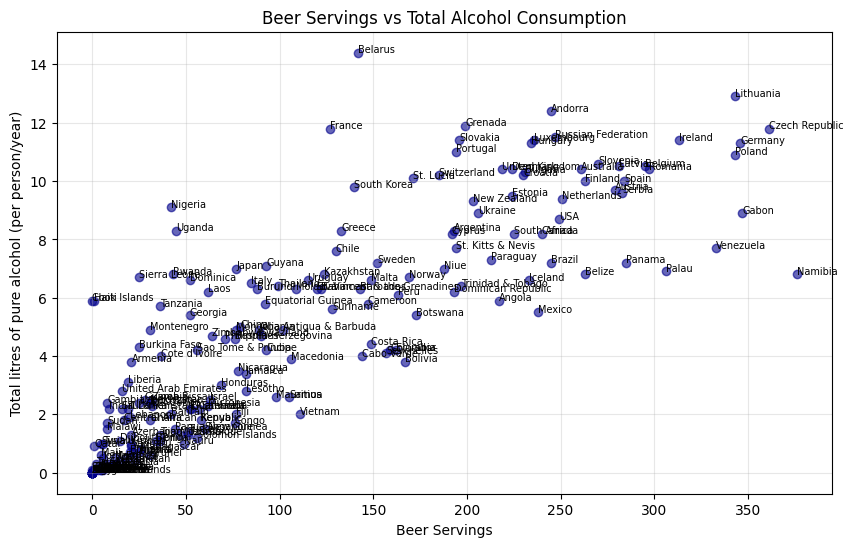

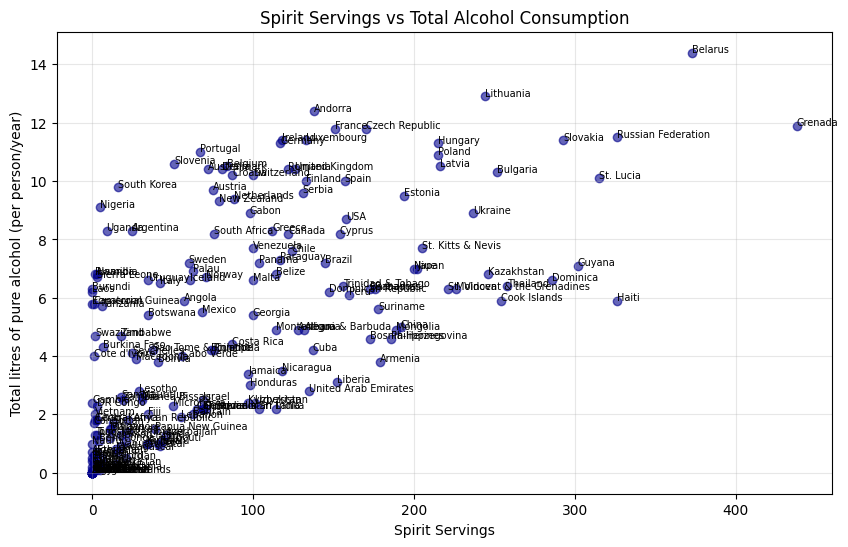

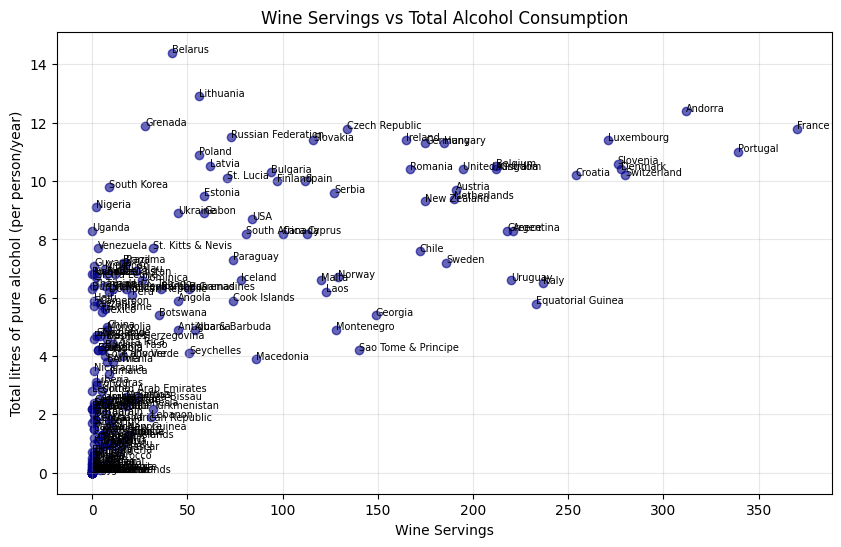

In [14]:
def simple_scatter(x, label_x):
    plt.figure(figsize=(10,6))
    plt.scatter(df_drinks[x], df_drinks["total_litres_of_pure_alcohol"], color="darkblue", alpha=0.6)

    for i, row in df_drinks.iterrows():
        plt.text(row[x], row["total_litres_of_pure_alcohol"], row["country"], fontsize=7)

    plt.title(f"{label_x} vs Total Alcohol Consumption")
    plt.xlabel(label_x)
    plt.ylabel("Total litres of pure alcohol (per person/year)")
    plt.grid(alpha=0.3)
    
    plt.show()

simple_scatter("beer_servings", "Beer Servings")
simple_scatter("spirit_servings", "Spirit Servings")
simple_scatter("wine_servings", "Wine Servings")


## 6 Hipóteses

### 6.1 Hipótese I: países de religião majoritariamente islâmica consomem menos álcool?

Na religião islâmica, o consumo de álcool é considerado "haram", isto é, proibido pelas regras religiosas. Essa restrição influencia diretamente os padrões culturais e comportamentais das populações de países de maioria islâmica, refletindo-se em níveis muito baixos de consumo per capita. No contexto desta análise, observa-se que diversos países islâmicos aparecem nas menores categorias de consumo no mapa-múndi, o que sugere uma associação entre fatores religiosos e o baixo consumo de bebidas alcoólicas. Para investigar essa hipótese de forma mais rigorosa, os países foram agrupados segundo sua predominância religiosa e comparados estatisticamente quanto ao consumo total de álcool.

In [15]:
islamic_countries = [
    "Afghanistan","Pakistan","Bangladesh","Iran","Iraq","Saudi Arabia",
    "Somalia","Yemen","Sudan","Qatar","UAE","Oman","Kuwait","Bahrain",
    "Jordan","Libya","Morocco","Algeria","Tunisia","Turkey","Indonesia",
    "Malaysia","Mauritania"
]

df_drinks["is_islamic"] = df_drinks["country"].isin(islamic_countries)


In [16]:
df_drinks 

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category,category_numeric,is_islamic
0,Afghanistan,0,0,0,0.0,Very Low,0,True
1,Albania,89,132,54,4.9,Medium,2,False
2,Algeria,25,0,14,0.7,Very Low,0,True
3,Andorra,245,138,312,12.4,Very High,4,False
4,Angola,217,57,45,5.9,Medium,2,False
...,...,...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High,3,False
189,Vietnam,111,2,1,2.0,Low,1,False
190,Yemen,6,0,0,0.1,Very Low,0,True
191,Zambia,32,19,4,2.5,Low,1,False


In [17]:
df_drinks.groupby("is_islamic")["total_litres_of_pure_alcohol"].mean()

is_islamic
False    5.262573
True     0.477273
Name: total_litres_of_pure_alcohol, dtype: float64

In [18]:
group1 = df_drinks[df_drinks["is_islamic"] == True]["total_litres_of_pure_alcohol"]
group2 = df_drinks[df_drinks["is_islamic"] == False]["total_litres_of_pure_alcohol"]

ttest_ind(group1, group2, equal_var=False)

TtestResult(statistic=np.float64(-15.470475971143717), pvalue=np.float64(5.398577406024308e-35), df=np.float64(181.7551417789477))

In [19]:
result = ttest_ind(group1, group2, equal_var=False)

# Estatísticas descritivas
n1, n2 = len(group1), len(group2)
mean1, mean2 = group1.mean(), group2.mean()
std1, std2 = group1.std(), group2.std()

t_stat = float(result.statistic)
p_value = float(result.pvalue)
df = float(result.df)

print("Comparação de consumo de álcool: países islâmicos vs não-islâmicos")
print("-" * 70)
print(f"Grupo 1 (Islâmicos)    : n = {n1:3d} | média = {mean1:5.2f} L | desvio-padrão = {std1:5.2f}")
print(f"Grupo 2 (Não-islâmicos): n = {n2:3d} | média = {mean2:5.2f} L | desvio-padrão = {std2:5.2f}")
print("-" * 70)
print("Teste t de duas amostras independentes (Welch)")
print(f"t = {t_stat:6.2f}")
print(f"df ≈ {df:6.2f}")
print(f"p-valor = {p_value:.2e}")
print("-" * 70)

alpha = 0.05
if p_value < alpha:
    print(f"Como p < {alpha}, rejeitamos H0: as médias são iguais.")
    print("Conclusão: países de maioria islâmica consomem significativamente menos álcool.")
else:
    print(f"Como p ≥ {alpha}, não rejeitamos H0: não há evidência de diferença entre as médias.")

Comparação de consumo de álcool: países islâmicos vs não-islâmicos
----------------------------------------------------------------------
Grupo 1 (Islâmicos)    : n =  22 | média =  0.48 L | desvio-padrão =  0.62
Grupo 2 (Não-islâmicos): n = 171 | média =  5.26 L | desvio-padrão =  3.66
----------------------------------------------------------------------
Teste t de duas amostras independentes (Welch)
t = -15.47
df ≈ 181.76
p-valor = 5.40e-35
----------------------------------------------------------------------
Como p < 0.05, rejeitamos H0: as médias são iguais.
Conclusão: países de maioria islâmica consomem significativamente menos álcool.


### 6.2 Hipótese II: Entre beer (cerveja), wine (vinho) e spirits (destilados), qual variável explica melhor o consumo total de álcool?

O consumo total de álcool pode ser explicado por diferentes tipos de bebidas. A hipótese busca determinar qual dos três tipos (beer, wine, spirits) apresenta maior correlação com o consumo total

In [28]:
corr_beer = df_drinks['beer_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_wine = df_drinks['wine_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_spirits = df_drinks['spirit_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])

dados_corr = pd.DataFrame({
    'bebida': ['beer', 'wine', 'spirits'],
    'correlacao': [corr_beer, corr_wine, corr_spirits]
}).sort_values(by='correlacao')

dados_corr

,bebida,correlacao
2,spirits,0.654968
1,wine,0.667598
0,beer,0.835839


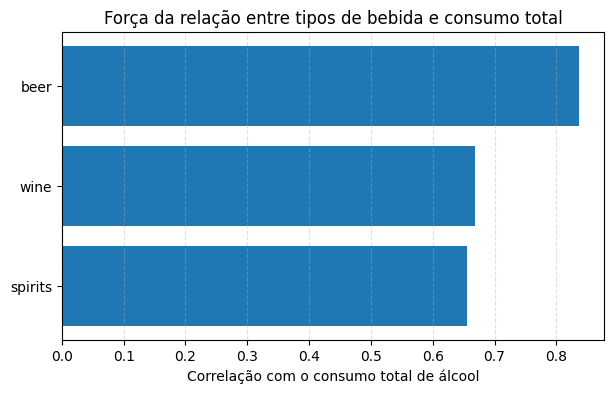

In [27]:
plt.figure(figsize=(7, 4))
plt.barh(dados_corr['bebida'], dados_corr['correlacao'])
plt.xlabel('Correlação com o consumo total de álcool')
plt.title('Força da relação entre tipos de bebida e consumo total')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()